In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Read in Data Set

In [2]:
raw_data = pd.read_csv('household_power_consumption.txt', sep=';', na_values='?', index_col=0,
                       parse_dates=[[0,1]], infer_datetime_format=True, dayfirst=True)

In [3]:
for i in range(raw_data.shape[1]):
    bad_cnt = raw_data.iloc[:, i].isnull().sum()
    print('Column %d has %d bad values.' % (i, bad_cnt))

Column 0 has 25979 bad values.
Column 1 has 25979 bad values.
Column 2 has 25979 bad values.
Column 3 has 25979 bad values.
Column 4 has 25979 bad values.
Column 5 has 25979 bad values.
Column 6 has 25979 bad values.


In [4]:
print(raw_data.shape)
# print(raw_data.iloc[4,[2,3,6,7,8]])
# print(raw_data.head)

(2075259, 7)


### Fill missing data with average curve
This method of filling the data will replace each missing value with the average of the last good value and the next good value. If there are multiple missing values, the last good value will be updated as each value is filled in. For example, if the series of data is [0, ?, ?, 4], the filled in set will be [0, 2, 3, 4].  
I think this is a reasonable way to fill in power data since power is continuous and can't change value instantaneously. It might be problematic for the regions where there are many values (multiple days worth) missing, though.

In [6]:
def FillAverageCurve(raw_data, full_row_outage=True, method='curve'):

    filled_data = raw_data.copy()
    if (full_row_outage):
        max_range = 1
    else:
        max_range = filled_data.shape[1]
    
    for col in range(max_range):
        last_row = -2

        null_series = filled_data.iloc[:, col].isnull()
        null_indices = np.where(null_series.values == True)[0].tolist()
        skip_cnt = 0
        for i in range(len(null_indices)):
            row = null_indices[i]

            if (last_row == row - 1):
                new_val = (last_good + next_good) / 2
                filled_data.iloc[row] = new_val
                if (method == 'curve'):
                    last_good = new_val
                continue

            if (i == len(null_indices) - 1):
                # This is the last null value in the column. The next row is good.
                filled_data.iloc[row] = (filled_data.iloc[row - 1] + filled_data.iloc[row + 1]) / 2
            else:
                good_idx = 0
                for k in range(i, len(null_indices)):
                    if (null_indices[k] != null_indices[k + 1] - 1):
                        good_idx = k
                        break
                    elif (k == len(null_indices) - 1):
                        good_idx = k
                next_good = filled_data.iloc[null_indices[good_idx] + 1]
                last_good = filled_data.iloc[row - 1]
                new_val = (last_good + next_good) / 2
                filled_data.iloc[row] = new_val
                if (method == 'curve'):
                    last_good = new_val
                last_row = row

        print('Column %d cleaned' % col)
    return filled_data

In [7]:
filled_data = FillAverageCurve(raw_data)#, method='flat')

Column 0 cleaned


In [8]:
# Check a few missing value locations to verify the fill worked correctly
print(raw_data.iloc[6838])
print(filled_data.iloc[6839])
print(filled_data.iloc[6840])
print(raw_data.iloc[6841])

Global_active_power        0.244
Global_reactive_power      0.000
Voltage                  242.290
Global_intensity           1.000
Sub_metering_1             0.000
Sub_metering_2             0.000
Sub_metering_3             0.000
Name: 2006-12-21 11:22:00, dtype: float64
Global_active_power        0.245
Global_reactive_power      0.000
Voltage                  242.015
Global_intensity           1.000
Sub_metering_1             0.000
Sub_metering_2             0.000
Sub_metering_3             0.000
Name: 2006-12-21 11:23:00, dtype: float64
Global_active_power        0.2455
Global_reactive_power      0.0000
Voltage                  241.8775
Global_intensity           1.0000
Sub_metering_1             0.0000
Sub_metering_2             0.0000
Sub_metering_3             0.0000
Name: 2006-12-21 11:24:00, dtype: float64
Global_active_power        0.246
Global_reactive_power      0.000
Voltage                  241.740
Global_intensity           1.000
Sub_metering_1             0.000
Sub_meter

### Add a new column for apparent power and sub-metering remainder
If I remember my power systems courses correctly, the power utility needs to consider apparent power, which is a combination of both active and reactive power. This next bit of code will calculate the apparent power and add it as a new column. This column will be useful if we want to do analysis related to how much power the utility needs to generate.

In [9]:
# Add apparent power column
filled_data['Sub_metering_remainder'] = (filled_data['Global_active_power'] * 1000 / 60 - 
                                         filled_data['Sub_metering_1'] - filled_data['Sub_metering_2'] - 
                                         filled_data['Sub_metering_3'])

filled_data['Global_apparent_power'] = np.sqrt(filled_data['Global_active_power']**2 +
                                              filled_data['Global_reactive_power']**2)

### Aggregate data by hour/day/month/season rather than by minute

In [10]:
hourly_data = filled_data.resample('H').agg({'Global_active_power': np.mean, 'Global_reactive_power': np.mean, 'Voltage': np.mean,
                                'Global_intensity': np.mean, 'Sub_metering_1': np.sum, 'Sub_metering_2': np.sum,
                                'Sub_metering_3': np.sum, 'Global_apparent_power': np.mean,
                                'Sub_metering_remainder': np.sum})

daily_data = filled_data.resample('D').agg({'Global_active_power': np.mean, 'Global_reactive_power': np.mean, 'Voltage': np.mean,
                                'Global_intensity': np.mean, 'Sub_metering_1': np.sum, 'Sub_metering_2': np.sum,
                                'Sub_metering_3': np.sum, 'Global_apparent_power': np.mean,
                                'Sub_metering_remainder': np.sum})

monthly_data = filled_data.resample('MS').agg({'Global_active_power': np.mean, 'Global_reactive_power': np.mean, 'Voltage': np.mean,
                                'Global_intensity': np.mean, 'Sub_metering_1': np.sum, 'Sub_metering_2': np.sum,
                                'Sub_metering_3': np.sum, 'Global_apparent_power': np.mean,
                                'Sub_metering_remainder': np.sum})

seasonal_data = filled_data.resample('QS-JUL').agg({'Global_active_power': np.mean, 'Global_reactive_power': np.mean, 'Voltage': np.mean,
                                'Global_intensity': np.mean, 'Sub_metering_1': np.sum, 'Sub_metering_2': np.sum,
                                'Sub_metering_3': np.sum, 'Global_apparent_power': np.mean,
                                'Sub_metering_remainder': np.sum})

# print(seasonal_data)

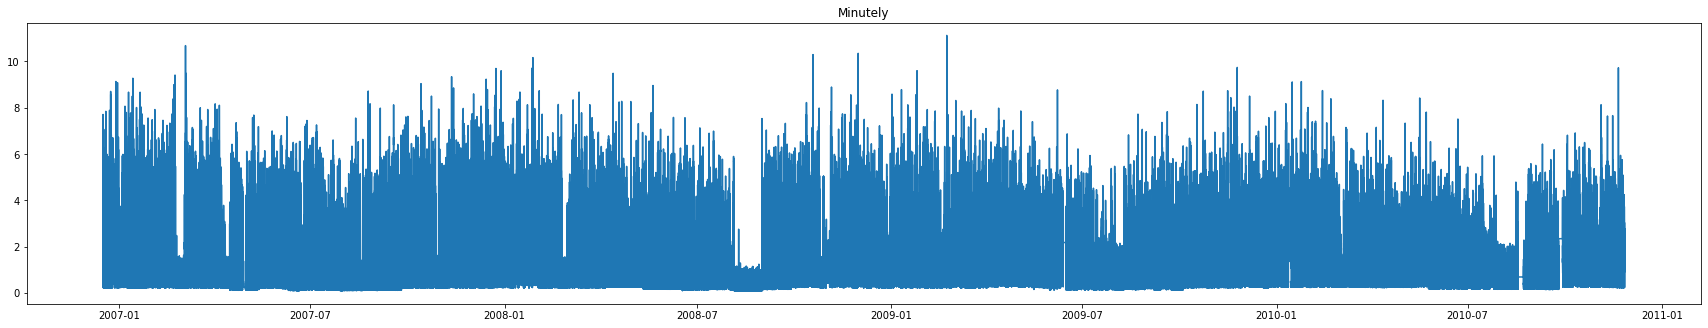

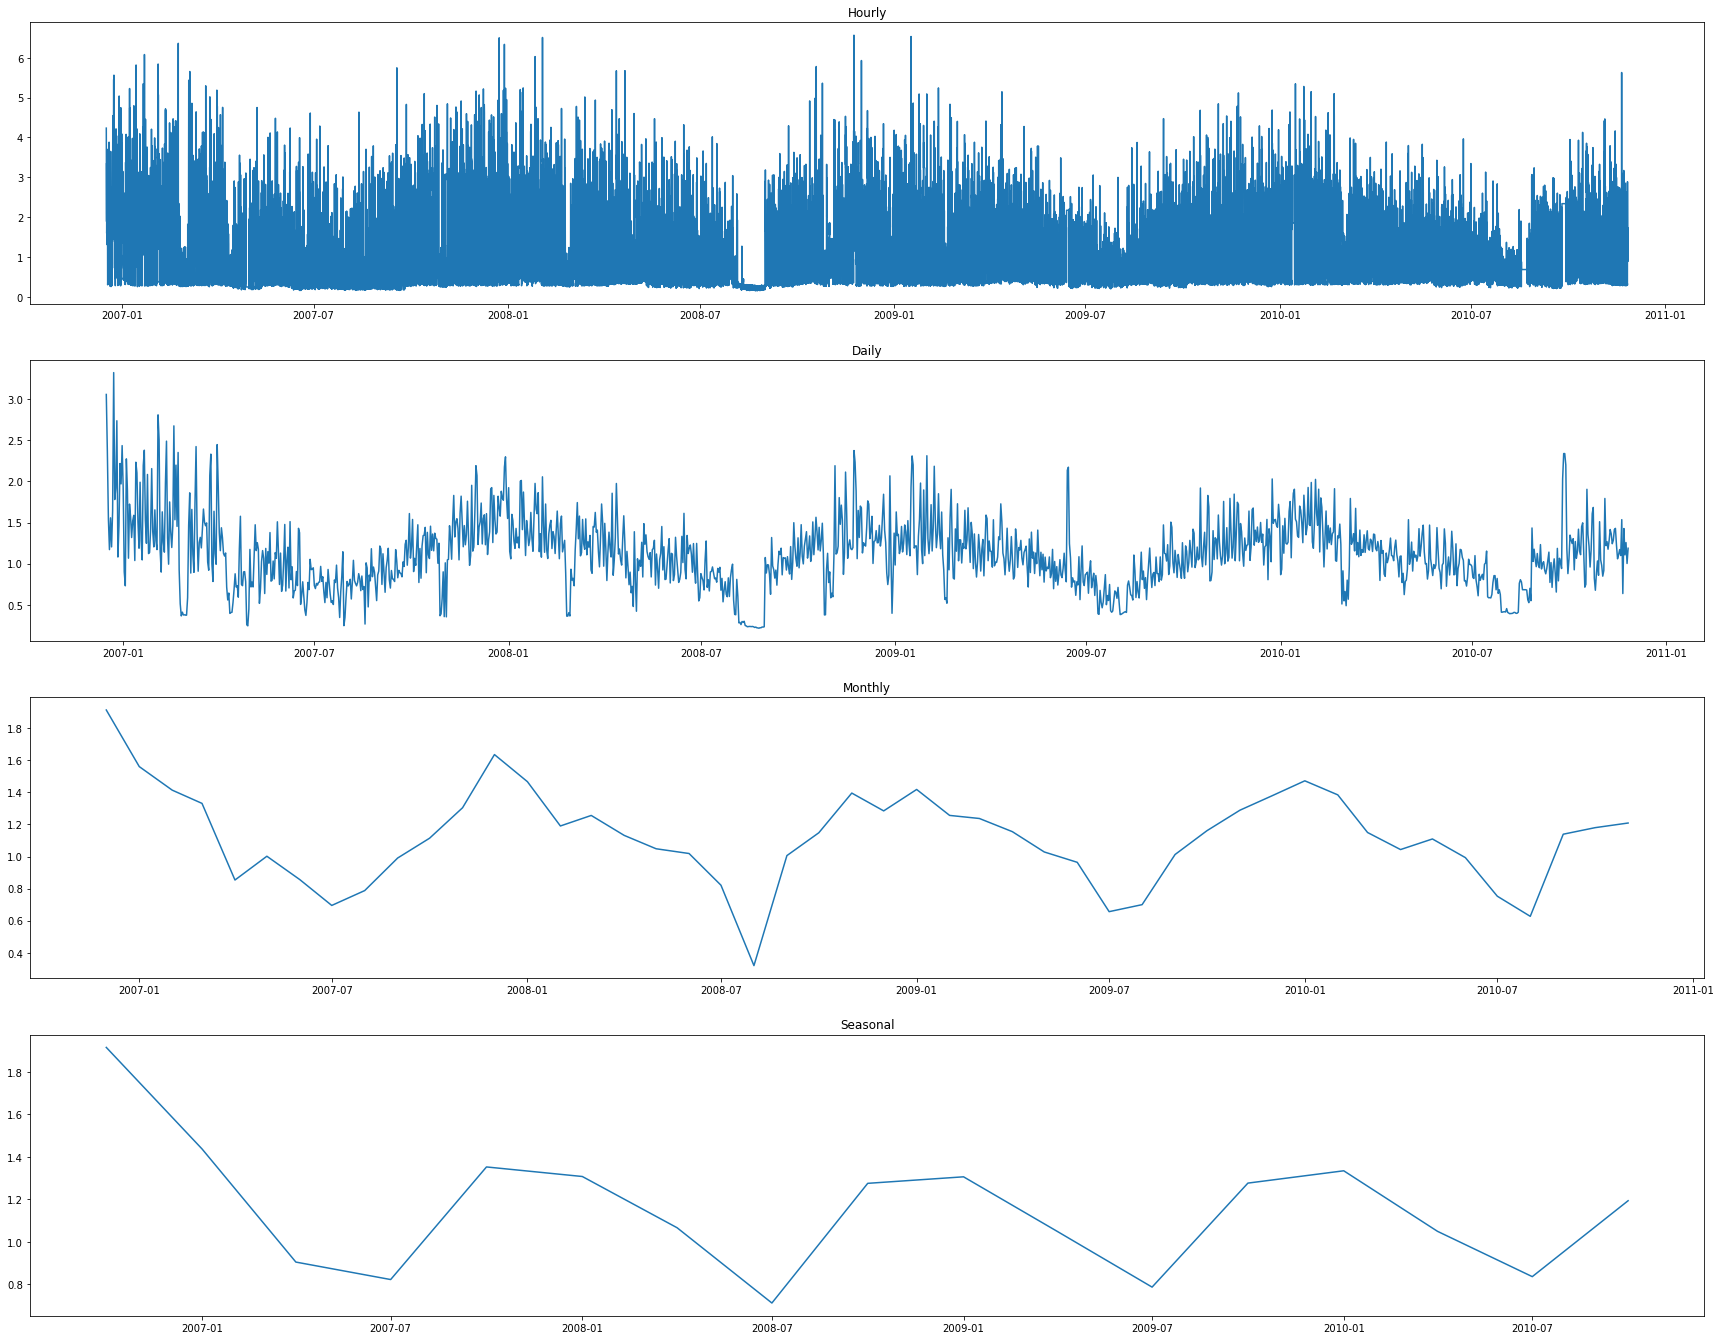

In [11]:
plt.figure(figsize=[30,30])
ax = plt.subplot(5, 1, 1)
plt.plot(filled_data['Global_apparent_power'])
plt.title('Minutely')
plt.figure(figsize=[30,30])
ax = plt.subplot(5, 1, 2)
plt.plot(hourly_data['Global_apparent_power'])
plt.title('Hourly')
ax = plt.subplot(5, 1, 3)
plt.plot(daily_data['Global_apparent_power'])
plt.title('Daily')
ax = plt.subplot(5, 1, 4)
plt.plot(monthly_data['Global_apparent_power'])
plt.title('Monthly')
ax = plt.subplot(5, 1, 5)
plt.plot(seasonal_data['Global_apparent_power'])
plt.title('Seasonal')
plt.show()

In [12]:
print(filled_data.iloc[0])

Global_active_power         4.216000
Global_reactive_power       0.418000
Voltage                   234.840000
Global_intensity           18.400000
Sub_metering_1              0.000000
Sub_metering_2              1.000000
Sub_metering_3             17.000000
Sub_metering_remainder     52.266667
Global_apparent_power       4.236671
Name: 2006-12-16 17:24:00, dtype: float64


### Classify power usage as low, average, high, or spike (increasing over last reading by some amount)

In [13]:
def AddClasses(data, max_low = 0.75, max_avg = 2.0, spike_coeff = 2):
    # Classes:
    # low = 0
    # average = 1
    # high = 2
    # spike = 3
    class_data = data.copy()

    gap = class_data['Global_apparent_power'].values
    cls_arr = np.zeros(class_data.shape[0])

    for i in range(len(gap)):
        pwr = gap[i]
        if (i != 0):
            last_pwr = gap[i-1]
        else:
            last_pwr = 0

        if (i != 0 and pwr >= last_pwr * spike_coeff):
            cls = 3
        elif (pwr < max_low):
            cls = 0
        elif (pwr < max_avg):
            cls = 1
        else:
            cls = 2

        cls_arr[i] = cls

    class_data['Class'] = cls_arr
    return class_data


In [14]:
class_data = AddClasses(hourly_data)

#### Split data into train/test based on year

In [15]:
train = class_data.loc[:'2009'][['Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'Sub_metering_remainder']]
train_classes = class_data.loc[:'2009']['Class']
test = class_data.loc['2010':][['Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'Sub_metering_remainder']]
test_classes = class_data.loc['2010':]['Class']

#### Run KNN on the hourly data  
Not sure if this will be valuable analysis, but let's try it anyway!

In [16]:
from sklearn.neighbors import KNeighborsClassifier

for i in range(1, 11):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(train, train_classes)
    
    predictions = knn.predict(test)
    score = knn.score(test, test_classes)
    print(score)
    correct = 0
    total = 0
    for k in range(len(predictions)):
        if (test_classes.iloc[k] == 3):
            total += 1
            if (predictions[k] == 3):
                correct += 1

    print('%d / %d spikes correct (%f)' % (correct, total, float(correct) / total))
    print()

0.8205354887597879
262 / 837 spikes correct (0.313023)

0.8714321798433948
110 / 837 spikes correct (0.131422)

0.8562768375852488
217 / 837 spikes correct (0.259259)

0.8699166456175802
124 / 837 spikes correct (0.148148)

0.8671381662035867
203 / 837 spikes correct (0.242533)

0.8735791866632988
140 / 837 spikes correct (0.167264)

0.869032583985855
196 / 837 spikes correct (0.234170)

0.8749684263702955
142 / 837 spikes correct (0.169654)

0.871179590805759
181 / 837 spikes correct (0.216249)

0.8764839605961101
146 / 837 spikes correct (0.174432)



Doesn't find spikes very well, but I can't say I expected it to. It doesn't know anything about what happened in the previous time step, just what the energy usage was for this time step.

### Time-series Forecasting - SARIMA 
Most of the code in this section comes from a tutorial found at https://www.bounteous.com/insights/2020/09/15/forecasting-time-series-model-using-python-part-one/

In [17]:
import statsmodels.api as sm

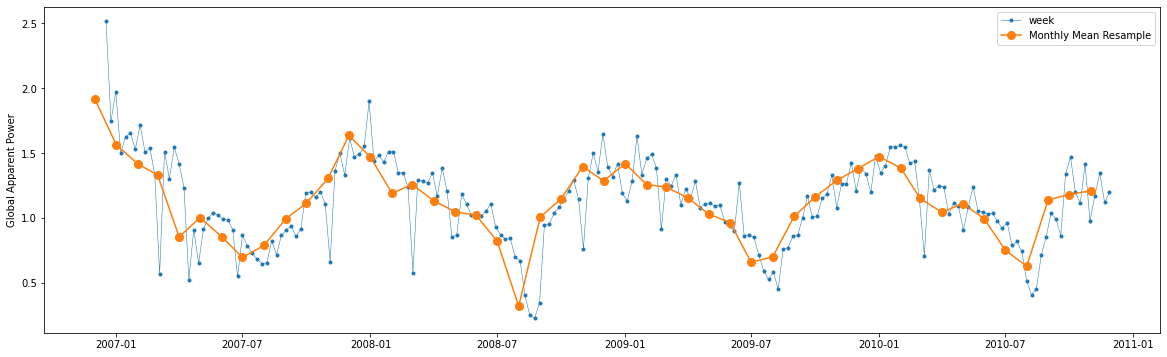

In [46]:
# From https://www.bounteous.com/insights/2020/09/15/forecasting-time-series-model-using-python-part-one/

# Set the scale of our data to use. Only really works well on weekly data (or probably larger scales).
# I've tried it on daily, but the parameter optimization takes ages, hasn't completed yet.
scale = 'weekly'
use_differencing = False
if (scale == 'hourly'):
    gap = hourly_data['Global_apparent_power']
    season = 8760
elif (sclae == 'daily'):
    gap = daily_data['Global_apparent_power']
    season = 365
elif (scale == 'weekly'):
    gap = weekly_data['Global_apparent_power']
    season = 52

# Plot the data along with a monthly mean to look for general trends.
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(gap, marker='.', linestyle='-', linewidth=0.5, label=scale)
ax.plot(monthly_data['Global_apparent_power'], marker='o', markersize=8, linestyle='-', label='Monthly Mean Resample')
ax.set_ylabel('Global Apparent Power')
ax.legend();

In [47]:
# Compute seasonal difference. Not sure if we want to do this or not.
if (use_differencing):
    gap = gap.diff(season)
    gap = gap.drop(gap.index.values[:season], axis=0)#.reset_index(drop=True)

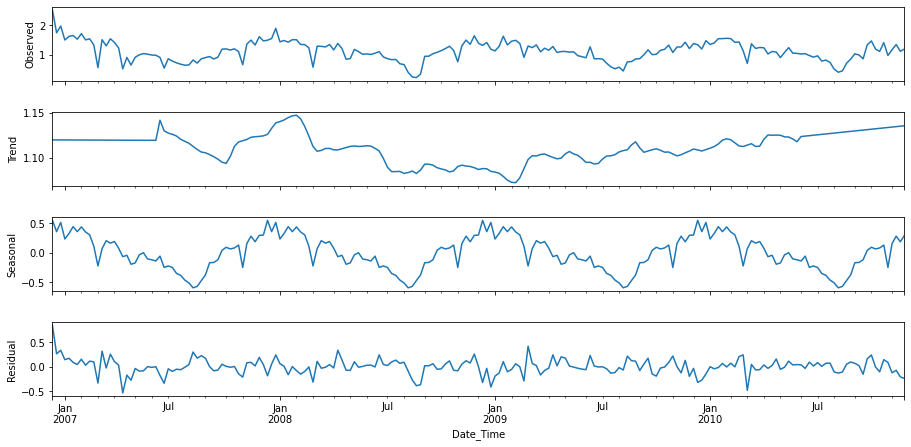

In [48]:
# Graphs to show seasonal_decompose
# The data shows a bit of a trend, but not much. Definite seasonality, most likely on a yearly period.
def seasonal_decompose (y):
    decomposition = sm.tsa.seasonal_decompose(y, model='additive',extrapolate_trend='freq')
    fig = decomposition.plot()
    fig.set_size_inches(14,7)
    plt.show()
    
seasonal_decompose(gap)#.loc['2007-01':'2007-02'])

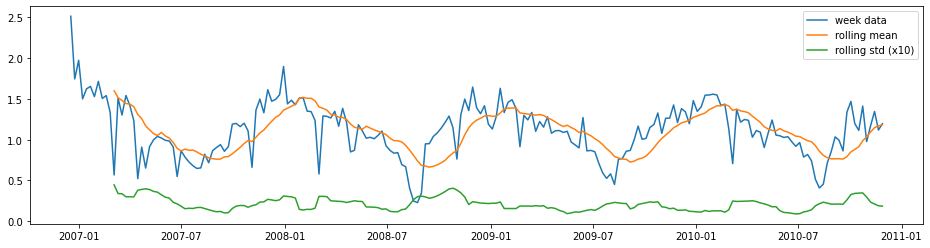

In [49]:
### plot for Rolling Statistic for testing Stationarity
def test_stationarity(timeseries, title):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=12).mean() 
    rolstd = pd.Series(timeseries).rolling(window=12).std()
    
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(timeseries, label= title)
    ax.plot(rolmean, label='rolling mean');
    ax.plot(rolstd, label='rolling std (x10)');
    ax.legend()
    
pd.options.display.float_format = '{:.8f}'.format
test_stationarity(gap,scale+' data')

I think the rolling mean here should be flatter for the data to be stationary. This can be achieved by using the seasonal differencing. But the ADF score says this is stationary enough as is.

In [50]:
# Compute the ADF statistic, which is a measure of how "stationary" the data is.
# The SARIMA algorithm works best on stationary data.
from statsmodels.tsa.stattools import adfuller

def ADF_test(timeseries, dataDesc):
    print(' > Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format
              (k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))
        
ADF_test(gap, scale+' data')

 > Is the week data stationary ?
Test statistic = -4.173
P-value = 0.001
Critical values :
	1%: -3.462818103072159 - The data is  stationary with 99% confidence
	5%: -2.8758145932936805 - The data is  stationary with 95% confidence
	10%: -2.574378674548251 - The data is  stationary with 90% confidence


#### Separate into Test and Train sets

In [51]:
y_to_train = gap[:'2009'] # dataset to train
y_to_test = gap['2010':] # last year for test  
predict_date = len(gap) - len(gap[:'2019-06-02']) # the number of data points for the test set
# print(len(gap), gap.shape)

#### Find Optimal Parameters

In [52]:
import itertools

def sarima_grid_search(y,seasonal_period):
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2],seasonal_period) for x in list(itertools.product(p, d, q))]
    
    mini = float('+inf')
    
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(y,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                results = mod.fit()
                
                if results.aic < mini:
                    mini = results.aic
                    param_mini = param
                    param_seasonal_mini = param_seasonal

#                 print('SARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            except:
                continue
    print('The set of parameters with the minimum AIC is: SARIMA{}x{} - AIC:{}'.format(param_mini, param_seasonal_mini, mini))

In [53]:
sarima_grid_search(gap, 52)

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

The set of parameters with the minimum AIC is: SARIMA(1, 1, 1)x(1, 0, 0, 52) - AIC:-76.02405912858569


| Scale | Differencing | Parameters |
| ----- | ------------ | ---------- |
| Daily | true | ()x() |
|       | false | ()x() |
| Weekly | true | (1, 0, 1)x(1, 0, 0, 52) |
|        | false | (1, 1, 1)x(1, 0, 0, 52) |

#### Generate and Evaluate **Model**

In [55]:
# Call this function after pick the right(p,d,q) for SARIMA based on AIC               
def sarima_eva(y,order,seasonal_order,seasonal_period,pred_date,y_to_test):
    # fit the model 
    mod = sm.tsa.statespace.SARIMAX(y,
                                order=order,
                                seasonal_order=seasonal_order,
                                enforce_stationarity=False,
                                enforce_invertibility=False)

    results = mod.fit()
    print(results.summary().tables[1])
    
    results.plot_diagnostics(figsize=(16, 8))
    plt.show()
    
    # The dynamic=False argument ensures that we produce one-step ahead forecasts, 
    # meaning that forecasts at each point are generated using the full history up to that point.
    pred = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=False)
    pred_ci = pred.conf_int()
    y_forecasted = pred.predicted_mean
    mse = ((y_forecasted - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = False {}'.format(seasonal_period,round(np.sqrt(mse), 2)))

    ax = y.plot(label='observed')
    y_forecasted.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Sessions')
    plt.legend()
    plt.show()

    # A better representation of our true predictive power can be obtained using dynamic forecasts. 
    # In this case, we only use information from the time series up to a certain point, 
    # and after that, forecasts are generated using values from previous forecasted time points.
    pred_dynamic = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=True, full_results=True)
    pred_dynamic_ci = pred_dynamic.conf_int()
    y_forecasted_dynamic = pred_dynamic.predicted_mean
    mse_dynamic = ((y_forecasted_dynamic - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = True {}'.format(seasonal_period,round(np.sqrt(mse_dynamic), 2)))

    ax = y.plot(label='observed')
    y_forecasted_dynamic.plot(label='Dynamic Forecast', ax=ax,figsize=(14, 7))
    ax.fill_between(pred_dynamic_ci.index,
                    pred_dynamic_ci.iloc[:, 0],
                    pred_dynamic_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Sessions')

    plt.legend()
    plt.show()
    
    return (results)

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2185      0.122      1.787      0.074      -0.021       0.458
ma.L1         -0.6610      0.101     -6.577      0.000      -0.858      -0.464
ar.S.L52       0.3232      0.048      6.795      0.000       0.230       0.416
sigma2         0.0337      0.003      9.623      0.000       0.027       0.041


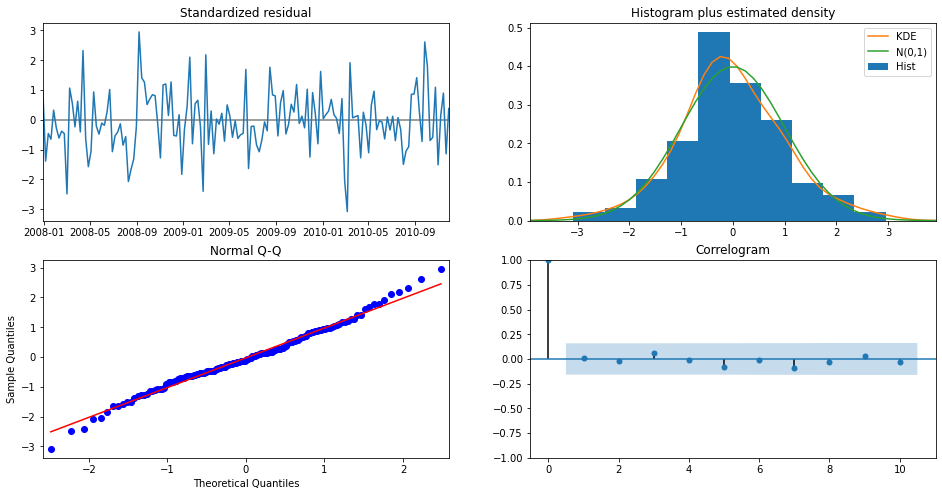

The Root Mean Squared Error of SARIMA with season_length=52 and dynamic = False 0.19


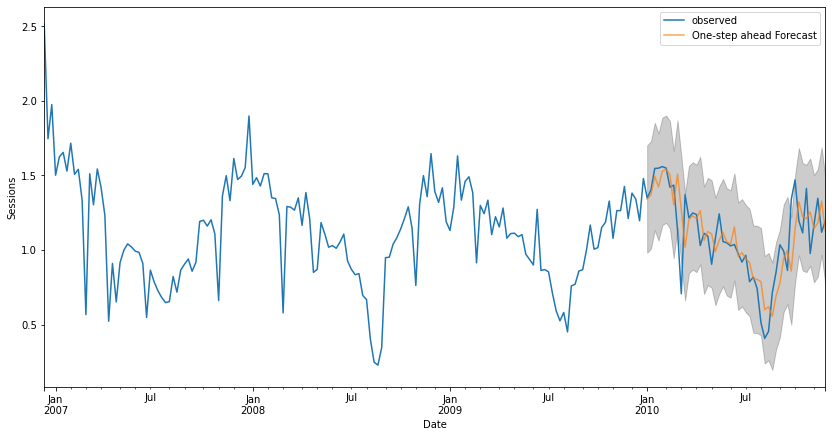

The Root Mean Squared Error of SARIMA with season_length=52 and dynamic = True 0.3


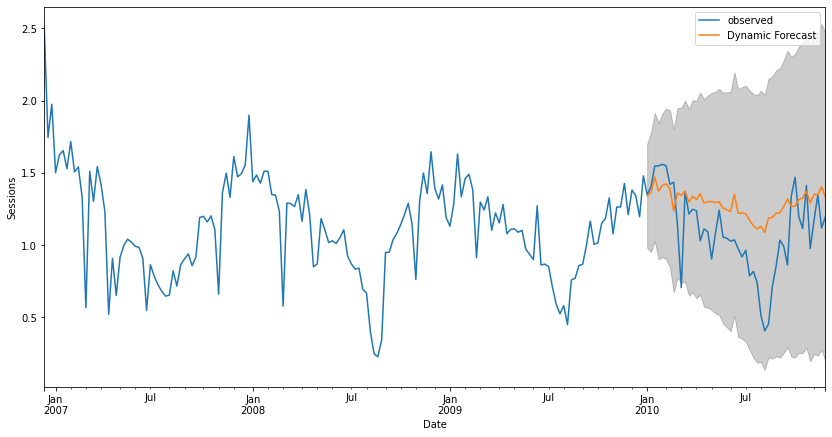

In [56]:
# You have to manually change the parameters here.
model = sarima_eva(gap,(1, 1, 1),(1, 0, 0, 52),season,y_to_test.index[0],y_to_test)

In the above, we can see that the model fits the data fairly well from several bits of evidence.  
* In the top-left chart, we can note that the p-value for most of the coefficients is below 0.05, indicating that they are significant with 95% confidence.
* In the top-right chart, the KDE matches up fairly well with the Normal distribution, indicating that the residuals are normally distributed.
* In the bottom-left chart, the data points mostly fall along the line. I believe this also indicates that the residuals follows a Normal distribution.
* The bottom-right chart shows that the residuals have a very low autocorrelation. Also a good thing, although I'm not entirely sure why. That's just what I've been told.
* In the bottom graphs, we can see that the forecasts match the test data fairly well.

#### Forecast Future Data

In [57]:
def forecast(model,predict_steps,y):
    
    pred_uc = model.get_forecast(steps=predict_steps)

    #SARIMAXResults.conf_int, can change alpha,the default alpha = .05 returns a 95% confidence interval.
    pred_ci = pred_uc.conf_int()

    ax = y.plot(label='observed', figsize=(14, 7))
#     print(pred_uc.predicted_mean)
    pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.25)
    ax.set_xlabel('Date')
    ax.set_ylabel(y.name)

    plt.legend()
    plt.show()
    
    # Produce the forcasted tables 
    pm = pred_uc.predicted_mean.reset_index()
    pm.columns = ['Date','Predicted_Mean']
    pci = pred_ci.reset_index()
    pci.columns = ['Date','Lower Bound','Upper Bound']
    final_table = pm.join(pci.set_index('Date'), on='Date')
    
    return (final_table)

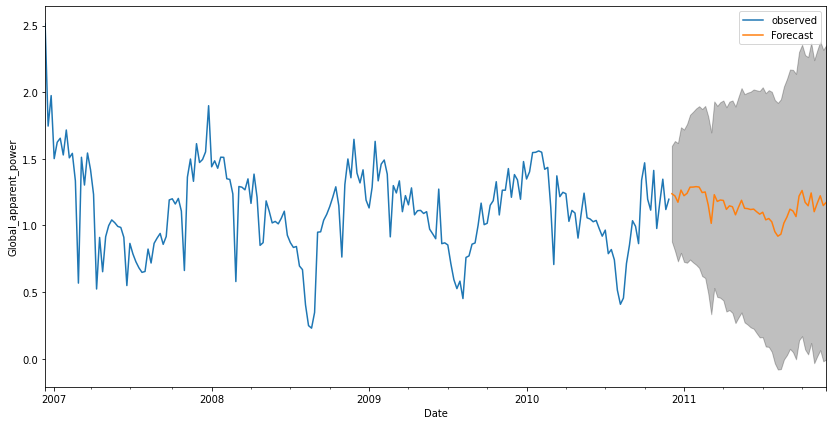

,Date,Predicted_Mean,Lower Bound,Upper Bound
0,2010-12-05,1.23723482,0.87754208,1.59692757
1,2010-12-12,1.22130270,0.80949809,1.63310732
2,2010-12-19,1.17361701,0.72971428,1.61751973
3,2010-12-26,1.26494170,0.79371432,1.73616909
4,2011-01-02,1.22263752,0.72611103,1.71916401


In [58]:
final_table = forecast(model,52,gap)
final_table.head()

The forecast looks like it follows the general trend of previous years a bit, but it is much flatter. The confidence interval is also very wide, encompassing basically the full range of the data. Given that, I think this model might be decent at prediction, but I'm not very confident in it.